In [1]:
import warnings

from sympy import im
warnings.filterwarnings("ignore")

import os
import re
import jieba
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
from transformers import RobertaPreTrainedModel
from sklearn.model_selection import train_test_split
from ark_nlp.factory.utils.seed import set_seed
from transformers import AutoModel, AutoModelForPreTraining, AutoTokenizer
from ark_nlp.nn.base.bert import BertForTokenClassification
from ark_nlp.nn.layer.global_pointer_block import GlobalPointer, EfficientGlobalPointer
from ark_nlp.model.ner.global_pointer_bert import GlobalPointerBert
from ark_nlp.model.ner.global_pointer_bert import GlobalPointerBertConfig
from ark_nlp.model.ner.global_pointer_bert import Dataset
from ark_nlp.model.ner.global_pointer_bert import Task
from ark_nlp.model.ner.global_pointer_bert import get_default_model_optimizer
from ark_nlp.model.ner.global_pointer_bert import Tokenizer

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# plt.rcParams['axes.unicode_minus']=False
# plt.rcParams["figure.figsize"] = (20, 5)
# color = ["#2639E9", "#F76E6C", "#FE7715"]
tqdm.pandas(desc="inference")

In [3]:
def E_trans_to_C(string):
    E_pun = u',.!?[]()<>"\''
    C_pun = u'，。！？【】（）《》“‘'
    table= {ord(f):ord(t) for f,t in zip(E_pun,C_pun)}
    return string.translate(table)

In [4]:
test = pd.read_csv("data/test.csv", sep="\t")
train = pd.read_csv("data/train.csv", sep="\t")

In [5]:
ts = test[["text"]]
ts["dataset"] = "test"

tr = train[["text"]]
tr["dataset"] = "train"

In [6]:
data = tr.append(ts).reset_index(drop=True)

In [7]:
data["length"] = data["text"].str.len()

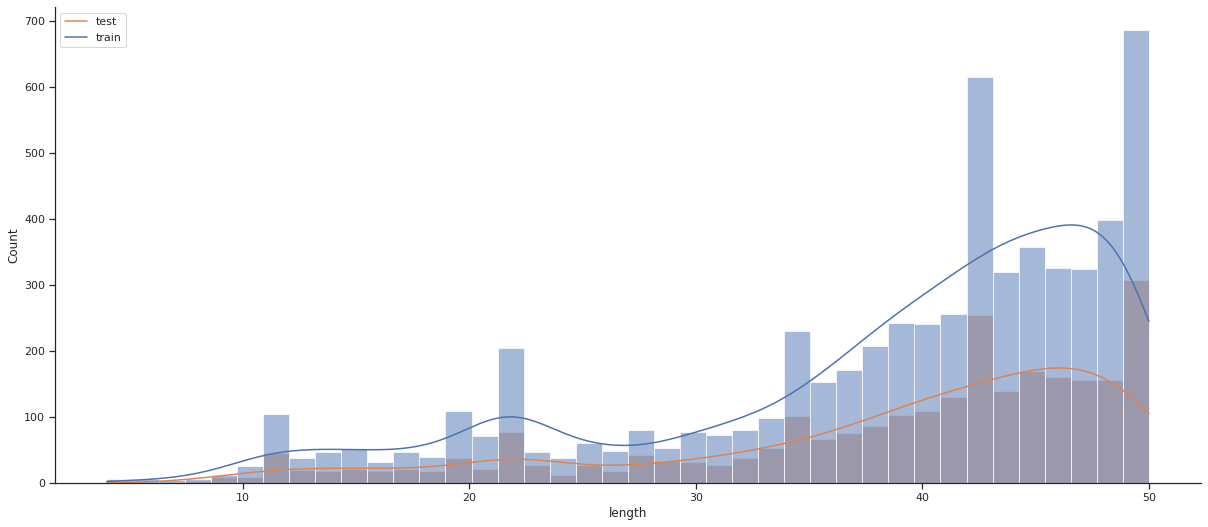

In [28]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
g = sns.displot(data, x="length", kde=True, hue="dataset", legend=False)
plt.gcf().set_size_inches(20, 8)
plt.legend(labels=["test", "train"])
plt.savefig("text_length.png")

In [ ]:
test["text"] = test["text"].apply(lambda line: E_trans_to_C(re.sub("[\(《：；→，。、\-”]+$", "", line.strip())))
train["text"] = train["text"].apply(lambda line: E_trans_to_C(re.sub("[\(《：→；，。、\-”]+$", "", line.strip())))
train["tag"] = train["tag"].apply(lambda x: [E_trans_to_C(i) for i in eval(str(x))])

In [ ]:
pseudo = pd.read_csv("data/pseudo.csv", sep="\t")
pseudo["text"] = pseudo["text"].apply(lambda line: E_trans_to_C(re.sub("[\(《：→；，。、\-”]+$", "", line.strip())))
pseudo["tag"] = pseudo["tag"].apply(lambda x: [E_trans_to_C(i) for i in eval(str(x))])

In [ ]:
train = pd.concat([train, pseudo]).reset_index(drop=True)

In [ ]:
# from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline
# model = AutoModelForTokenClassification.from_pretrained('uer/roberta-base-finetuned-cluener2020-chinese')
# tokenizer = AutoTokenizer.from_pretrained('uer/roberta-base-finetuned-cluener2020-chinese')
# ner = pipeline('ner', model=model, tokenizer=tokenizer)

In [ ]:
# def inference(text):
#     items = ner(text)
#     items_index = [i["index"] for i in items]
#     result = []
#     entity_index = []
#     for index, x in enumerate(items_index):
#         entity_index.append(index)
#         if x + 1 not in items_index:
#             result.append(text[items[min(entity_index)]["start"]:items[max(entity_index)]["end"]])
#             entity_index = []
    
#     return result

In [ ]:
# test["tag"] = test["text"].progress_apply(inference)

In [ ]:
# test.rename(columns={"tags": "tag"})[["tag"]].to_csv("data/submit.csv", index=False, encoding="utf-8")

In [ ]:
train["label"] = train.progress_apply(lambda row: [["LOC", *i.span()] for tag in row["tag"] for i in re.finditer(tag, row["text"])], axis=1)

In [ ]:
datalist = []

for _, row in train.iterrows():
    entity_labels = []
    for _type, _start_idx, _end_idx in row["label"]:
        entity_labels.append({
            'start_idx': _start_idx,
            'end_idx': _end_idx,
            'type': _type,
            'entity': row["text"][_start_idx: _end_idx]
    })

    datalist.append({
        'text': row["text"],
        'label': entity_labels
    })

In [ ]:
data = pd.DataFrame(datalist)
train_data_df, dev_data_df = train_test_split(data)

In [ ]:
ner_train_dataset = Dataset(train_data_df, categories=["LOC", "O"])
ner_dev_dataset = Dataset(dev_data_df, categories=ner_train_dataset.categories)

In [ ]:
tokenizer = Tokenizer(vocab='./roberta-base-finetuned-cluener2020-chinese', max_seq_len=52)

In [ ]:
ner_train_dataset.convert_to_ids(tokenizer)
ner_dev_dataset.convert_to_ids(tokenizer)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# 设置运行次数
num_epoches = 10
batch_size = 32

In [ ]:
config = GlobalPointerBertConfig.from_pretrained('./roberta-base-finetuned-cluener2020-chinese', num_labels=len(ner_train_dataset.cat2id))

In [ ]:
class GlobalPointerBert(RobertaPreTrainedModel):
    def __init__(
        self,
        config,
        encoder_trained=False,
        head_size=64
    ):
        super().__init__(config)
        self.num_labels = 2
        self.bert = AutoModel.from_pretrained("./roberta-base-finetuned-cluener2020-chinese")

        for param in self.bert.parameters():
            param.requires_grad = encoder_trained

        self.global_pointer = GlobalPointer(
            self.num_labels,
            head_size,
            768
        )

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        **kwargs
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
            output_hidden_states=True
        ).hidden_states

        sequence_output = outputs[-1]

        logits = self.global_pointer(sequence_output, mask=attention_mask)

        return logits

In [ ]:
dl_module = GlobalPointerBert.from_pretrained('./roberta-base-finetuned-cluener2020-chinese', config=config, encoder_trained=True)

In [ ]:
optimizer = get_default_model_optimizer(dl_module)

In [ ]:
from ark_nlp.factory.lr_scheduler import get_default_linear_schedule_with_warmup
t_total = len(ner_train_dataset) // batch_size * num_epoches
scheduler = get_default_linear_schedule_with_warmup(optimizer, t_total, warmup_ratio=0.1)

In [ ]:
from torch.utils.data import DataLoader
from ark_nlp.factory.optimizer import get_optimizer
from ark_nlp.factory.utils.attack import FGM

In [ ]:
class AttackTask(Task):
    
    def _on_train_begin(
        self,
        train_data,
        validation_data,
        batch_size,
        lr,
        params,
        shuffle,
        num_workers=0,
        train_to_device_cols=None,
        **kwargs
    ):
        if hasattr(train_data, 'id2cat'):
            self.id2cat = train_data.id2cat
            self.cat2id = {v_: k_ for k_, v_ in train_data.id2cat.items()}

        # 在初始化时会有class_num参数，若在初始化时不指定，则在训练阶段从训练集获取信息
        if self.class_num is None:
            if hasattr(train_data, 'class_num'):
                self.class_num = train_data.class_num
            else:
                warnings.warn("The class_num is None.")

        if train_to_device_cols is None:
            self.train_to_device_cols = train_data.to_device_cols
        else:
            self.train_to_device_cols = train_to_device_cols

        train_generator = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            collate_fn=self._train_collate_fn
        )
        self.train_generator_lenth = len(train_generator)

        self.optimizer = get_optimizer(self.optimizer, self.module, lr, params)
        self.optimizer.zero_grad()

        self.module.train()
        
        self.fgm = FGM(self.module)

        self._on_train_begin_record(**kwargs)

        return train_generator
    
    def _on_backward(
        self,
        inputs,
        outputs,
        logits,
        loss,
        gradient_accumulation_steps=1,
        **kwargs
    ):
        # 如果GPU数量大于1
        if self.n_gpu > 1:
            loss = loss.mean()
        # 如果使用了梯度累积，除以累积的轮数
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps

        loss.backward()
        
        self.fgm.attack()
        logits = self.module(**inputs)
        _, attck_loss = self._get_train_loss(inputs, logits, **kwargs)
        attck_loss.backward()
        self.fgm.restore()

        if self.logs['epoch_loss'] / (self.logs['epoch_step'] + 1e-8) < 0.13:
            self.ema.update(self.module.parameters())
        
        self._on_backward_record(loss, **kwargs)

        return loss

In [ ]:
model = AttackTask(dl_module, optimizer, 'gpce', cuda_device=2, ema_decay=0.995, scheduler=scheduler, grad_clip=1.0)

In [ ]:
model.fit(
    ner_train_dataset,
    ner_dev_dataset,
    lr=5e-5,
    epochs=num_epoches,
    batch_size=batch_size,
)

In [ ]:
class GlobalPointerNERPredictor(object):
    """
    GlobalPointer命名实体识别的预测器

    Args:
        module: 深度学习模型
        tokernizer: 分词器
        cat2id (:obj:`dict`): 标签映射
    """  # noqa: ignore flake8"

    def __init__(
        self,
        module,
        tokernizer,
        cat2id
    ):
        self.module = module
        self.module.task = 'TokenLevel'

        self.cat2id = cat2id
        self.tokenizer = tokernizer
        self.device = list(self.module.parameters())[0].device

        self.id2cat = {}
        for cat_, idx_ in self.cat2id.items():
            self.id2cat[idx_] = cat_

    def _convert_to_transfomer_ids(
        self,
        text
    ):
        tokens = self.tokenizer.tokenize(text)
        token_mapping = self.tokenizer.get_token_mapping(text, tokens)

        input_ids = self.tokenizer.sequence_to_ids(tokens)
        input_ids, input_mask, segment_ids = input_ids

        zero = [0 for i in range(self.tokenizer.max_seq_len)]
        span_mask = [input_mask for i in range(sum(input_mask))]
        span_mask.extend([zero for i in range(sum(input_mask), self.tokenizer.max_seq_len)])
        span_mask = np.array(span_mask)

        features = {
            'input_ids': input_ids,
            'attention_mask': input_mask,
            'token_type_ids': segment_ids,
            'span_mask': span_mask
        }

        return features, token_mapping

    def _get_input_ids(
        self,
        text
    ):
        if self.tokenizer.tokenizer_type == 'vanilla':
            return self._convert_to_vanilla_ids(text)
        elif self.tokenizer.tokenizer_type == 'transfomer':
            return self._convert_to_transfomer_ids(text)
        elif self.tokenizer.tokenizer_type == 'customized':
            return self._convert_to_customized_ids(text)
        else:
            raise ValueError("The tokenizer type does not exist")

    def _get_module_one_sample_inputs(
        self,
        features
    ):
        return {col: torch.Tensor(features[col]).type(torch.long).unsqueeze(0).to(self.device) for col in features}

    def predict_one_sample(
        self,
        text='',
        threshold=0
    ):
        """
        单样本预测

        Args:
            text (:obj:`string`): 输入文本
            threshold (:obj:`float`, optional, defaults to 0): 预测的阈值
        """  # noqa: ignore flake8"

        features, token_mapping = self._get_input_ids(text)
        self.module.eval()

        with torch.no_grad():
            inputs = self._get_module_one_sample_inputs(features)
            scores = self.module(**inputs)[0].cpu()
            
        scores[:, [0, -1]] -= np.inf
        scores[:, :, [0, -1]] -= np.inf

        entities = []

        for category, start, end in zip(*np.where(scores > threshold)):
            if end-1 > token_mapping[-1][-1]:
                break
            if token_mapping[start-1][0] <= token_mapping[end-2][-1]:
                entitie_ = text[token_mapping[start-1][0]: token_mapping[end-2][-1]+1]
                if entitie_ == '':
                    continue
                entities.append(entitie_)

        return entities

In [ ]:
ner_predictor_instance = GlobalPointerNERPredictor(model.module, tokenizer, ner_train_dataset.cat2id)

In [ ]:
predict_results = []
pseudo_data = []

for _line in tqdm(test["text"].tolist()):
    label = set()
    for _preditc in ner_predictor_instance.predict_one_sample(_line, threshold=0.):
        label.add(_preditc)
    
    label = list(label)
    if len(label) > 0:
        pseudo_data.append([_line, label])

    predict_results.append(label)

In [ ]:
with open('gobal_pointer_submit.txt', 'w', encoding='utf-8') as f:
    f.write("tag\n")
    for _result in predict_results:
       f.write(f"{str(_result)}\n")

In [ ]:
pseudo_data = pd.DataFrame(pseudo_data, columns=["text", "tag"])
pseudo_data.to_csv("data/pseudo.csv", index=False, encoding="utf-8", sep="\t")